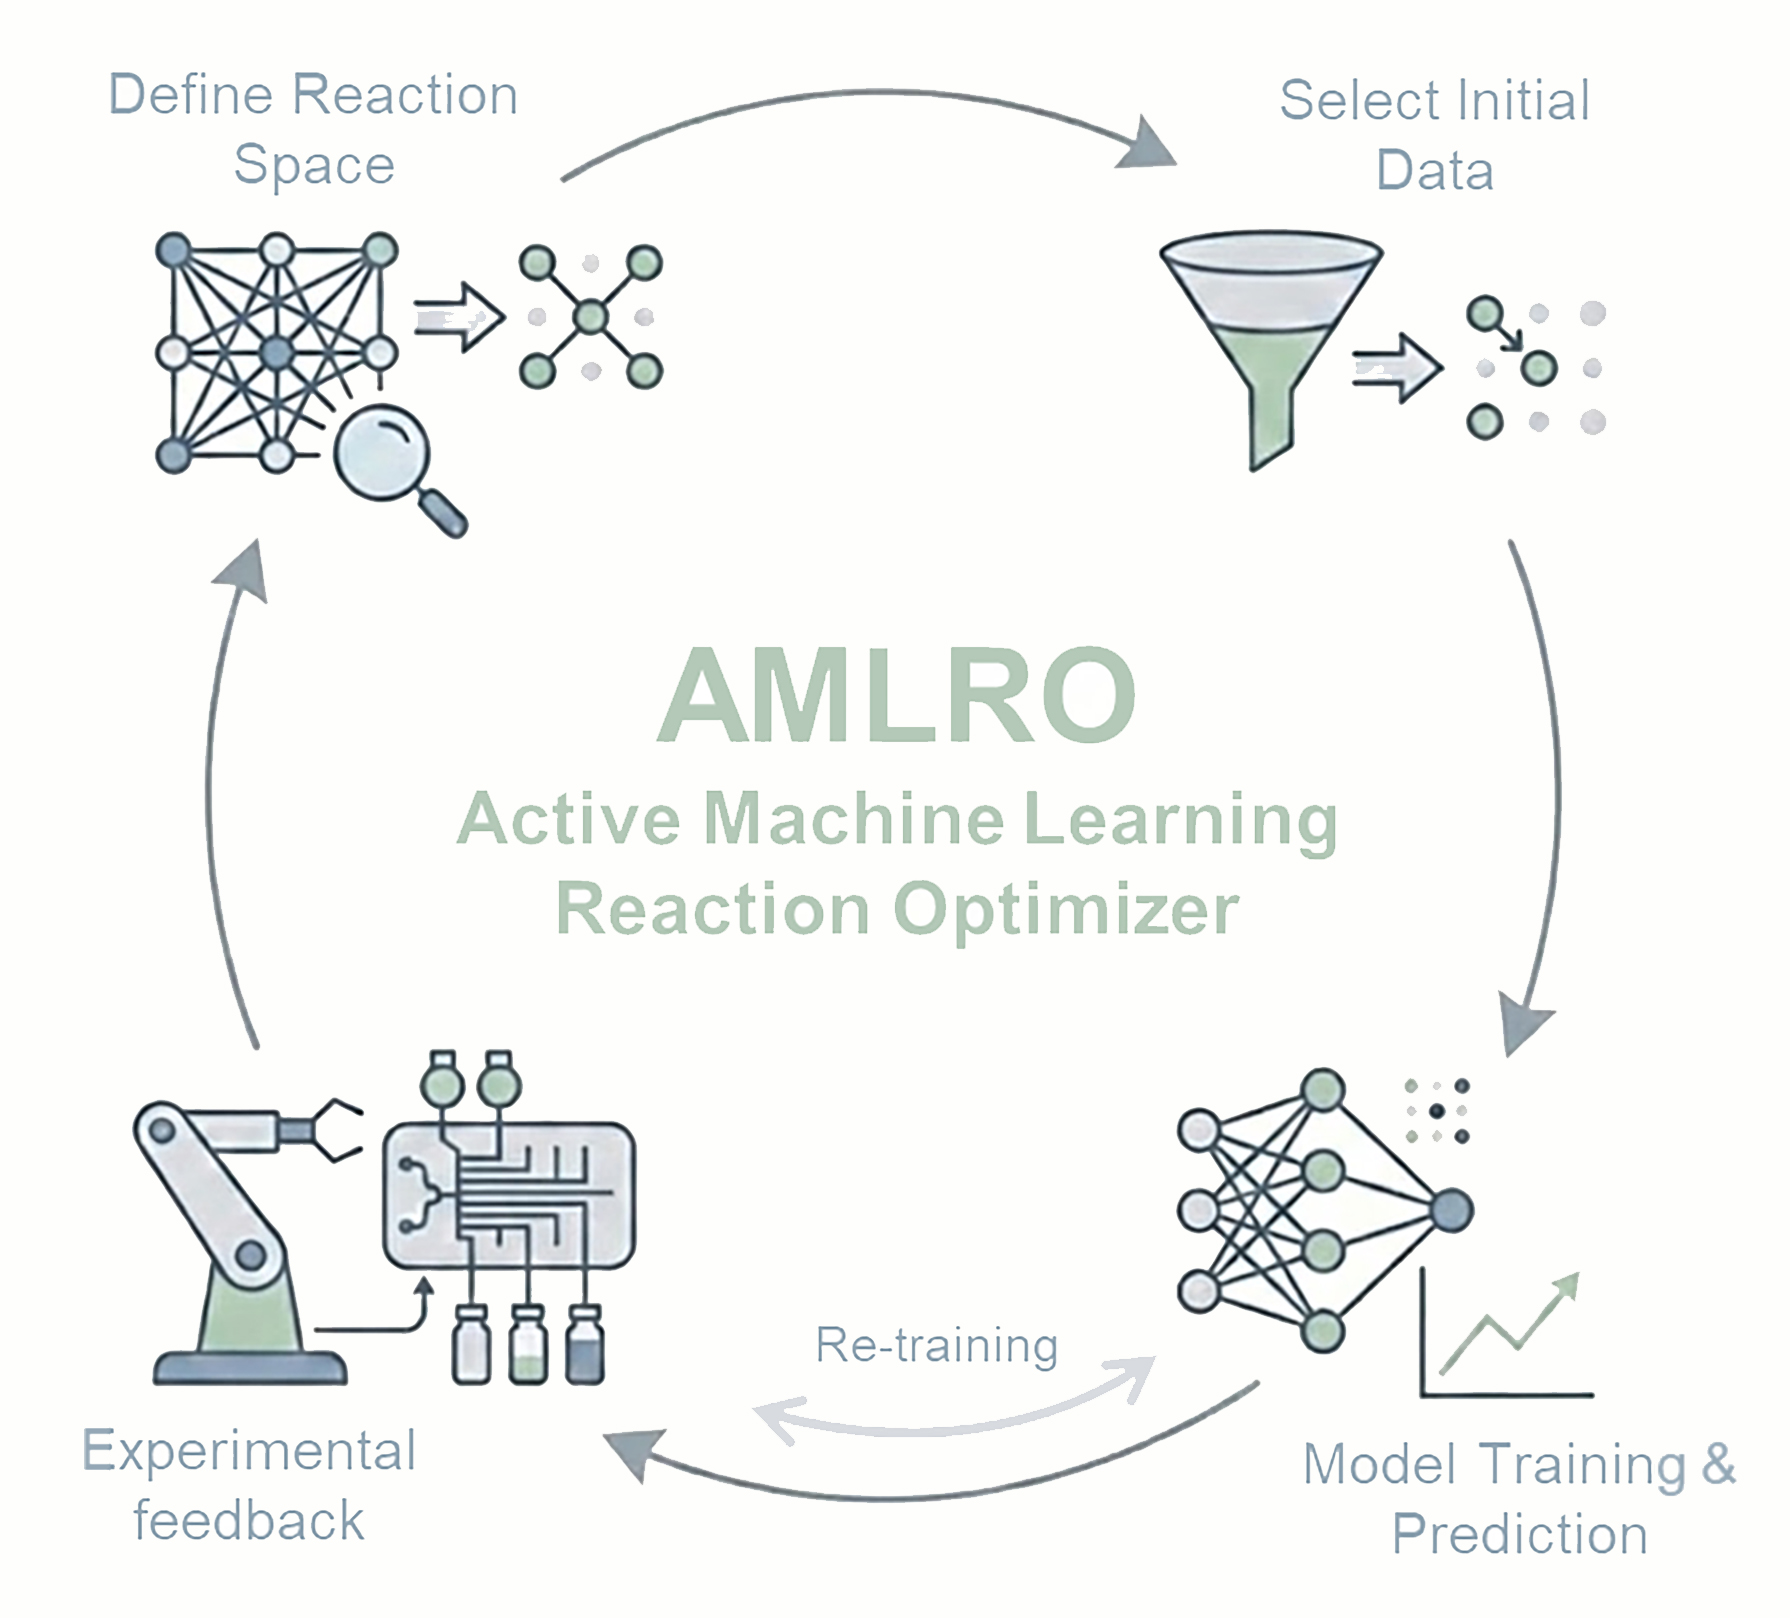

# AMLRO: Active Machine Learning Reaction Optimizer

**Interactive workflow for reaction optimization using machine learning**


# **Installation**

In [ ]:
# @title
%%capture
# Hide installation & imports
!pip install git+https://github.com/RxnRover/amlro.git
#!pip install -e amlro/

import sys
sys.path.append('/usr/local/lib/python3.x/dist-packages/')

import pandas as pd
import ipywidgets as widgets
from IPython.display import display, clear_output
import matplotlib.pyplot as plt




In [ ]:
# @title
from amlro.optimizer import get_optimized_parameters
from amlro.generate_reaction_conditions import get_reaction_scope
from amlro.generate_training_data import generate_training_data

## AMLRO Workflow Overview

AMLRO is divided into **3 steps**:

1 **Generate Reaction Space** - define all possible conditions  
2 **Generate Initial Training Data** - select a small subset and collect experimental results  
3 **Active Learning Optimization Loop** - iterative ML-guided selection of new reaction batches

> Users only interact with steps 2 & 3.


# **Define configurations**
The configuration dictionary specifies:

- Continuous reaction parameters (bounds, resolution, names)
- Categorical reaction parameters (explicit value lists)
- Optimization objectives and directions
- Sampling method - sobol, lhs or random
- Training set size
- Regression model - gb (gradient boosting),
                    rf (random forest),
                    knn (k nearest neighbor)
- Batch size - how many reaction suggestions needs in a active learning cycle

And other variables:
 exp_dir = Experiment directory

A minimal configuration dictionary **must contain all required keys**, even if
some sections (e.g., categorical variables) are empty.

In [ ]:
# AMLRO Experiment Directory
exp_dir = "amlro_demo"

# Reaction configuration
config = {
    "continuous": {
        "bounds": [[-2, 2], [-2, 2]],
        "resolutions": [0.1, 0.1],
        "feature_names": ["f1", "f2"],
    },
    "categorical": {
        "feature_names": [],
        "values": []
    },
    "objectives": ['yield'],
    "directions": ['max'],
    "sampling": 'lhs',
    "training_size": 5,
    "model": 'gb',
    "batch_size":2
}



# **Step 1: Generate Reaction Space**
Reaction space generation serves two purposes:

1. Construct the **full combinatorial reaction space** based on user-defined
   continuous and categorical parameters.
2. Select an **initial subset of reactions** for training using a chosen
   sampling strategy.

Please run the following cell/code line.

In [ ]:
# @title

get_reaction_scope(config=config, sampling=config["sampling"], training_size=config["training_size"],
                   write_files=True, exp_dir=exp_dir)

(       f1   f2
 0    -2.0 -2.0
 1    -2.0 -1.9
 2    -2.0 -1.8
 3    -2.0 -1.7
 4    -2.0 -1.6
 ...   ...  ...
 1676  2.0  1.6
 1677  2.0  1.7
 1678  2.0  1.8
 1679  2.0  1.9
 1680  2.0  2.0
 
 [1681 rows x 2 columns],
        f1   f2
 0    -2.0 -2.0
 1    -2.0 -1.9
 2    -2.0 -1.8
 3    -2.0 -1.7
 4    -2.0 -1.6
 ...   ...  ...
 1676  2.0  1.6
 1677  2.0  1.7
 1678  2.0  1.8
 1679  2.0  1.9
 1680  2.0  2.0
 
 [1681 rows x 2 columns],
     f1   f2
 0  2.0  0.9
 1 -1.0 -2.0
 2 -0.1  1.7
 3  0.9 -1.0
 4 -1.2 -0.1)

# -----------------------------
# **Step 2: Initial Training Data (interactive)**
# -----------------------------
This step collects **experimental results** for the first batch of reactions.
- Suggested reaction parameters are shown in the table.
- Enter your measured objective value(s) and click **Submit & Continue**.
- The notebook will automatically move to the next batch.

In [ ]:
# @title


training_conditions = pd.read_csv(exp_dir + '/training_combo.csv')
display(training_conditions)

iteration = 0
parameters = []
objectives = []

columns = ["Batch", "Reaction Condition"] + config["objectives"]
results_df = pd.DataFrame(columns=columns)

def get_initial_training_input():
    global iteration, parameters, objectives, results_df
    if iteration >= config["training_size"]:
        generate_training_data(exp_dir=exp_dir, config=config,
                               parameters=parameters, obj_values=objectives,
                               termination=True)
        print("✅ Initial training data collection complete")
        display(results_df)
        return

    # Generate next parameter set
    parameters = generate_training_data(exp_dir=exp_dir, config=config,
                                       parameters=parameters, obj_values=objectives)

    clear_output(wait=True)
    print(f"Batch {iteration+1}: Suggested Parameters {parameters}")
    display(results_df)

    # Input widget for experimental result
    input_widgets = [widgets.FloatText(description=obj, value=0.0) for obj in config["objectives"]]
    display(widgets.HTML("<b>Enter Experimental Results:</b>"))
    display(widgets.HBox([widgets.Label(value=str(parameters))] + input_widgets))

    submit_button = widgets.Button(description="Submit & Continue")

    def on_submit(_):
        global iteration, objectives, results_df
        exp_values = [cell.value for cell in input_widgets]
        objectives = exp_values
        new_row = pd.DataFrame([[iteration+1, str(parameters)] + exp_values], columns=columns)
        results_df = pd.concat([results_df, new_row], ignore_index=True)

        iteration += 1
        clear_output(wait=True)
        get_initial_training_input()

    submit_button.on_click(on_submit)
    display(submit_button)

# Start Step 2
get_initial_training_input()


writing data to training dataset files...
Training set generation completed..
✅ Initial training data collection complete


,Batch,Reaction Condition,yield
0,1,"[2.0, 0.9]",54.0
1,2,"[-1.0, -2.0]",76.0
2,3,"[-0.1, 1.7]",45.0
3,4,"[0.9, -1.0]",67.0
4,5,"[-1.2, -0.1]",46.0


# -----------------------------
#**Step 3: Active Learning Optimization Loop**
# -----------------------------
This step uses the **current dataset** to train a model and predict the next batch of reactions:
- Enter results for each batch.
- Click **Submit & Continue** to move to the next cycle.
- Click **Stop** to terminate the optimization early.

Note: If you click Stop, the AMLRO will terminate the optimization and will not save the current inputs.
To record the results for the last batch, enter the values and click Submit before clicking Stop.

❌ Optimization stopped by user.


,Cycle,Batch,Reaction Condition,yield


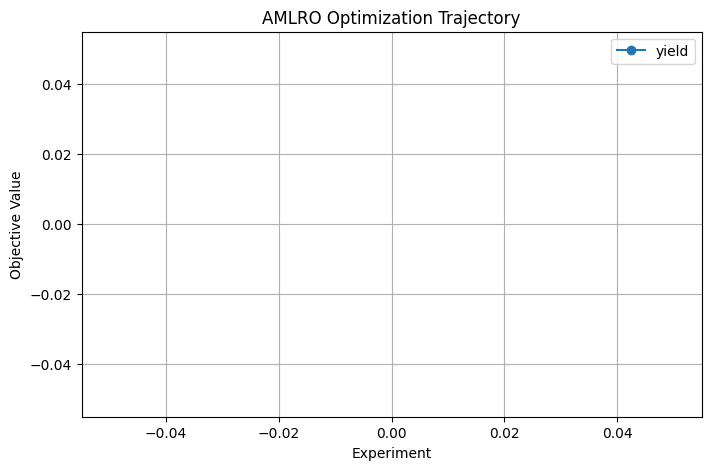

In [ ]:
# @title

cycle = 0
parameters = []
objectives = []

columns = ["Cycle", "Batch", "Reaction Condition"] + config["objectives"]
results_df = pd.DataFrame(columns=columns)

def run_active_learning():
    global cycle, parameters, objectives, results_df
    # Generate next batch
    parameters = get_optimized_parameters(exp_dir=exp_dir, config=config,
                                          parameters_list=parameters,
                                          objectives_list=objectives,
                                          batch_size=config['batch_size'], model= config['model'])

    clear_output(wait=True)
    print(f"🔁 Cycle {cycle+1}")
    display(results_df)

    input_rows = []
    for i, param_set in enumerate(parameters):
        widgets_row = [widgets.FloatText(description=obj, value=0.0) for obj in config["objectives"]]
        input_rows.append((i+1, param_set, widgets_row))
        display(widgets.HTML(f"<b>Batch {i+1}: Reaction Condition</b> {param_set}"))
        display(widgets.HBox(widgets_row))

    submit_button = widgets.Button(description="Submit & Continue", button_style="success")
    stop_button = widgets.Button(description="Stop", button_style="danger")

    def on_submit(_):
        global cycle, parameters, objectives, results_df
        new_rows = []
        new_objectives = []
        for batch, param_set, widgets_row in input_rows:
            vals = [w.value for w in widgets_row]
            new_objectives.append(vals)
            new_rows.append([cycle+1, batch, str(param_set)] + vals)

        objectives = new_objectives
        results_df = pd.concat([results_df, pd.DataFrame(new_rows, columns=columns)],
                               ignore_index=True)
        cycle += 1
        run_active_learning()

    def on_stop(_):
        clear_output(wait=True)
        print("❌ Optimization stopped by user.")
        display(results_df)
        plot_results()

    submit_button.on_click(on_submit)
    stop_button.on_click(on_stop)
    display(submit_button, stop_button)

def plot_results():
    df = results_df
    plt.figure(figsize=(8,5))
    for obj in config["objectives"]:
        plt.plot(df.index, df[obj], marker='o', label=obj)
    plt.xlabel("Experiment")
    plt.ylabel("Objective Value")
    plt.title("AMLRO Optimization Trajectory")
    plt.grid(True)
    plt.legend()
    plt.show()

# Start Step 3
run_active_learning()

# **Download Optimization Files**

In [ ]:
# @title
import shutil
from google.colab import files

def download_results(_):
    shutil.make_archive(exp_dir, 'zip', exp_dir)
    files.download(f"{exp_dir}.zip")

download_button = widgets.Button(
    description="⬇ Download Results",
    button_style="success"
)

download_button.on_click(download_results)
display(download_button)


Button(button_style='success', description='⬇ Download Results', style=ButtonStyle())

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>